# Aluna: Alana Viana
# Tarefa Análise de Votos

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import svm, preprocessing
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,  classification_report, confusion_matrix, accuracy_score

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

In [32]:
df_2006_2010 = pd.read_csv("data/eleicoes_2006_a_2010.csv", index_col = "nome")
df_2014 = pd.read_csv("data/eleicoes_2014.csv", index_col = "nome")
all_data = pd.concat([df_2006_2010, df_2014])
#all_data = all_data.drop(columns=["ano"])
all_data = all_data.drop(columns=["sequencial_candidato"])
#all_data = all_data.drop(columns=["nome"])

## Pré-Processamento

(tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso).

#### Normalização 

In [33]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

#### Dummies e NA

In [34]:
# aplicando nos dados de 2006 e 2010
all_data = pd.get_dummies(all_data) # dummies
all_data = all_data.fillna(all_data.mean()) # valores ausentes

In [35]:
X_train_2006 = all_data[(all_data["ano"]==2006)]
y_train_2006 = X_train_2006["votos"]
X_train_2006 = X_train_2006.drop(columns=["votos"])
X_train_2006 = X_train_2006.drop(columns=["ano"])


X_test_2010 = all_data[(all_data["ano"]==2010)]
y_test_2010 = X_test_2010["votos"]
X_test_2010 = X_test_2010.drop(columns=["votos"])
X_test_2010 = X_test_2010.drop(columns=["ano"])

X_train_2006_2010 = all_data[(all_data["ano"]!=2014)]
y_train_2006_2010 = X_train_2006_2010["votos"]
X_train_2006_2010 = X_train_2006_2010.drop(columns=["votos"])
X_train_2006_2010 = X_train_2006_2010.drop(columns=["ano"])

X_test_2014 = all_data[(all_data["ano"]==2014)]
y_test_2014 = X_test_2014["votos"]
X_test_2014 = X_test_2014.drop(columns=["votos"])
X_test_2014 = X_test_2014.drop(columns=["ano"])

###  Variáveis e métodos auxiliares

In [36]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

## Modelos de ML 

Modelos treinados com dados de 2006 e Test com dados de 2014 e comparados entre si

### 1 Modelo: Ridge

In [37]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 60, 65] # The higher the regularization the less prone our model will be to overfit
cv_rmse_ridge = [rmse_cv(Ridge(alpha = alpha), X_train_2006, y_train_2006).mean() 
            for alpha in alphas]
cv_rmse_ridge = pd.Series(cv_rmse_ridge, index = alphas)

Text(0, 0.5, 'rmse')

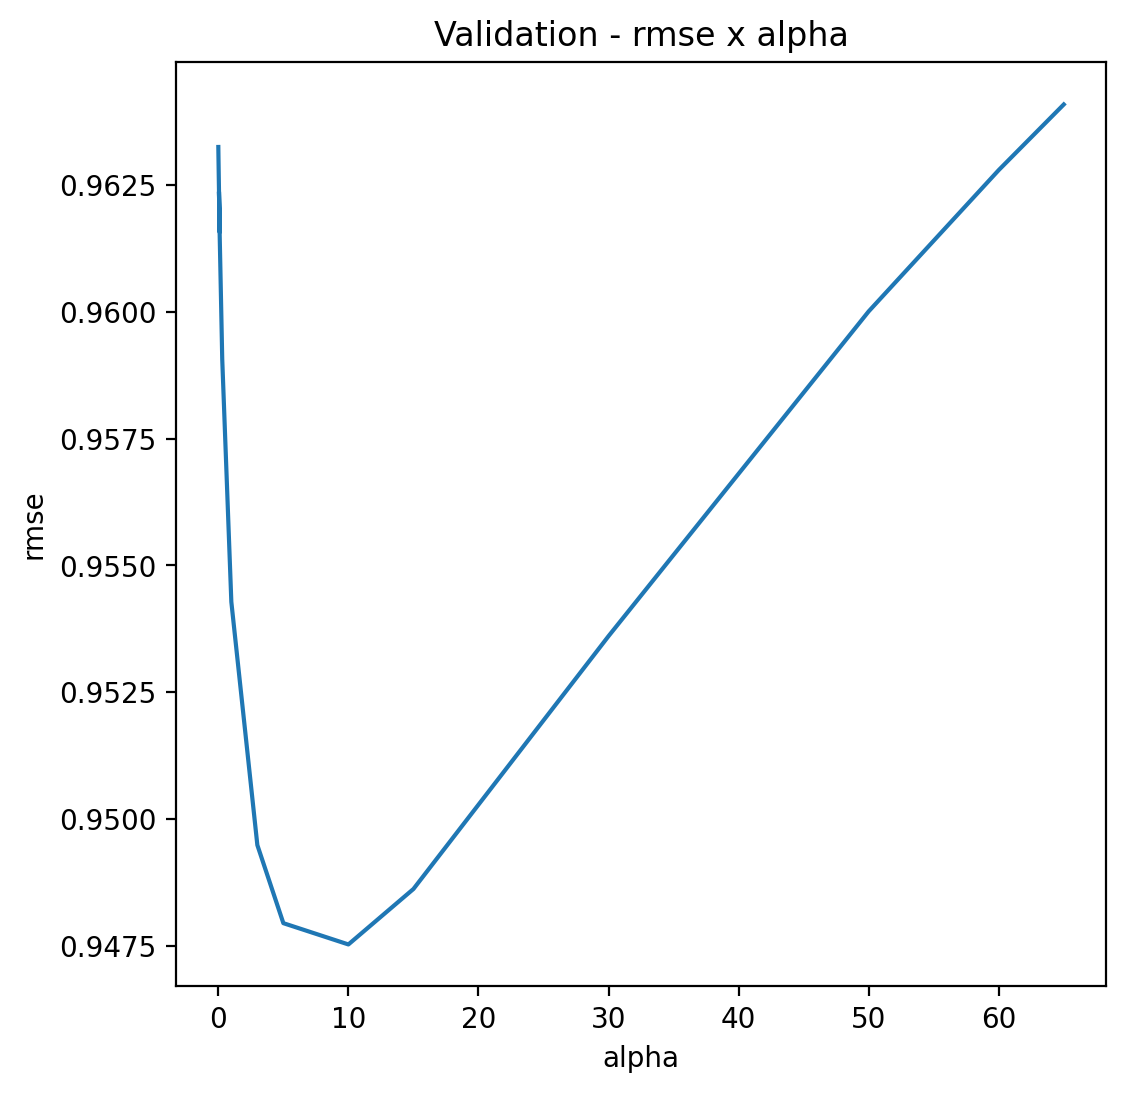

In [38]:
cv_ridge = pd.Series(cv_rmse_ridge, index = alphas)
cv_ridge.plot(title = "Validation - rmse x alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [39]:
print("rmse Ridge: {}".format(cv_ridge.min()))

rmse Ridge: 0.947523367008684


In [40]:
# alpha com o menor rmse
print("alpha com menor RMSE: {}".format(cv_ridge.index[[cv_ridge.values == cv_ridge.min()]]))

alpha com menor RMSE: Float64Index([10.0], dtype='float64')


c:\users\gisel\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [41]:
model_ridge = Ridge(alpha=10)
model_ridge.fit(X_train_2006, y_train_2006)

Ridge(alpha=10)

In [42]:
y_pred_ridge = model_ridge.predict(X_test_2010)

In [43]:
rmse = model_ridge.score(X_train_2006, y_train_2006)
print("Ridge - Coefficient of determination(R^2) no treino: {}".format(rmse))

Ridge - Coefficient of determination(R^2) no treino: 0.7812321037771028


In [44]:
rmse = model_ridge.score(X_test_2010, y_test_2010)
print("Ridge - Coefficient of determination(R^2) no teste: {}".format(rmse))

Ridge - Coefficient of determination(R^2) no teste: 0.7115923115052459


In [45]:
rmse = -cross_val_score(model_ridge, X_train_2006, y_train_2006, scoring = "neg_mean_squared_error", cv = 5 )
print("Ridge - RMSE - Cross validation - no treino: {} ".format(rmse.mean()))

Ridge - RMSE - Cross validation - no treino: 0.8979306727718914 


In [46]:
rmse = -cross_val_score(model_ridge, X_test_2010, y_test_2010, scoring = "neg_mean_squared_error", cv = 5 )
print("Ridge - RMSE - Cross validation - no teste: {} ".format(rmse.mean()))

Ridge - RMSE - Cross validation - no teste: 1.0626674086463284 


#### Ridge Coeficientes 

In [47]:
coef_ridge = pd.Series(model_ridge.coef_, index = X_train_2006.columns)
print("Ridge picked " + str(sum(coef_ridge != 0)) + " variables and eliminated the other " +  str(sum(coef_ridge == 0)) + " variables")

Ridge picked 227 variables and eliminated the other 55 variables


Text(0.5, 1.0, 'Coefficients in the Ridge Model')

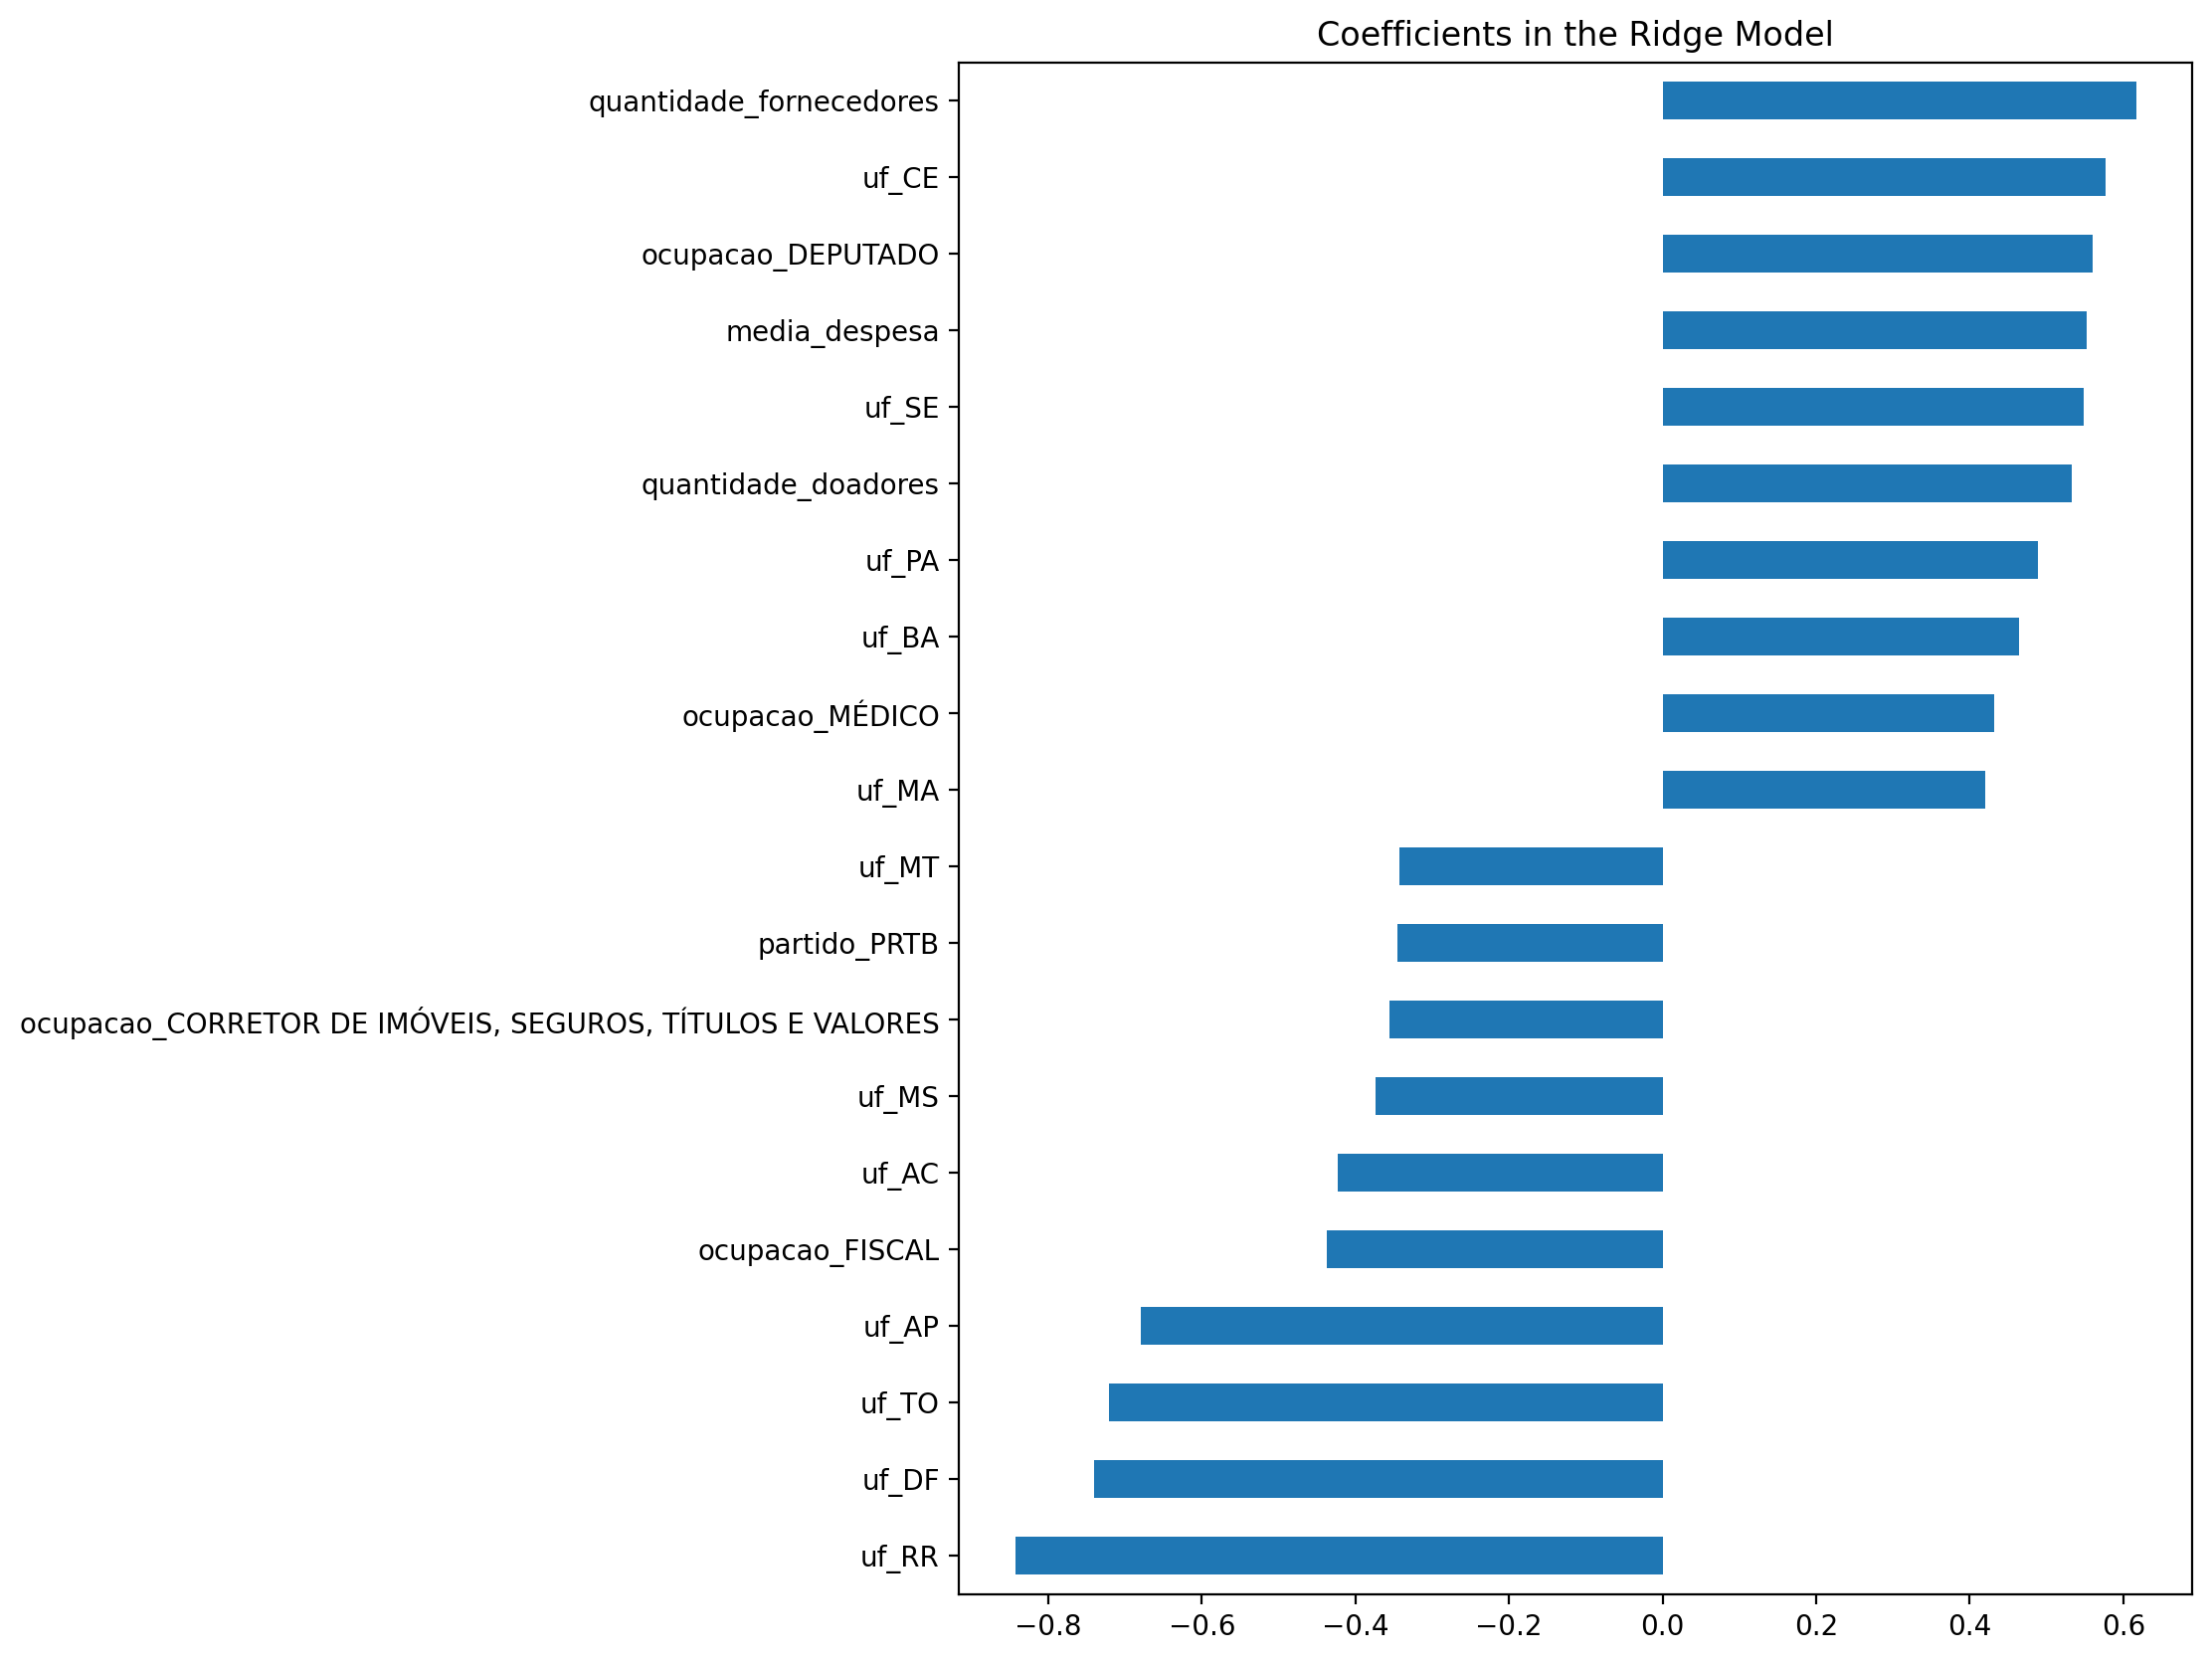

In [48]:
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_ridge.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

<AxesSubplot:title={'center':'Ridge - residuals x preds'}, xlabel='preds', ylabel='residuals'>

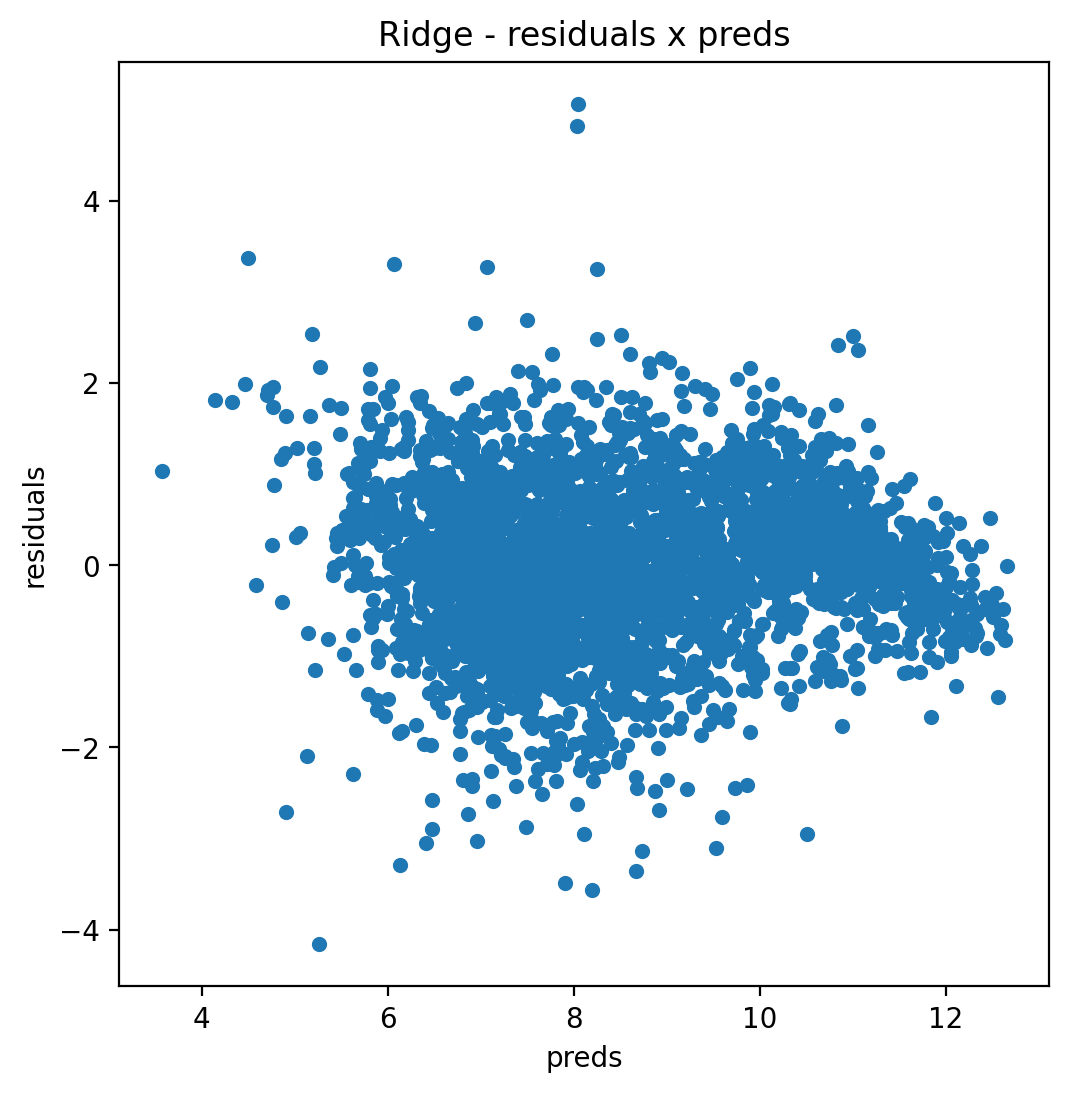

In [49]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train_2006), "true": y_train_2006})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter", title = "Ridge - residuals x preds")

### 2 Modelo: Lassso 

In [50]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=60000000).fit(X_train_2006, y_train_2006)

In [51]:
rmse = model_lasso.score(X_train_2006, y_train_2006)
print("Lasso - RMSE - treino: {}".format(rmse))

Lasso - Coefficient of determination(R^2) no treino: 0.7789366822394865


In [75]:
rmse = model_lasso.score(X_test_2010, y_test_2010)
print("Lasso - RMSE - Teste: {}".format(rmse))

Lasso - RMSE - treino: 0.7107681532080334


In [52]:
rmse = -cross_val_score(model_ridge, X_train_2006, y_train_2006, scoring = "neg_mean_squared_error", cv = 5 )
print("Lasso - RMSE - Cross validation - Treino: {} ".format(rmse.mean()))

Lasso - RMSE - Cross validation - no treino: 0.8979306727718914 


#### Lasso coeficient

In [53]:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train_2006.columns)

In [54]:
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " + str(sum(coef_lasso == 0)) + " variables")

Lasso picked 103 variables and eliminated the other 179 variables


In [55]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

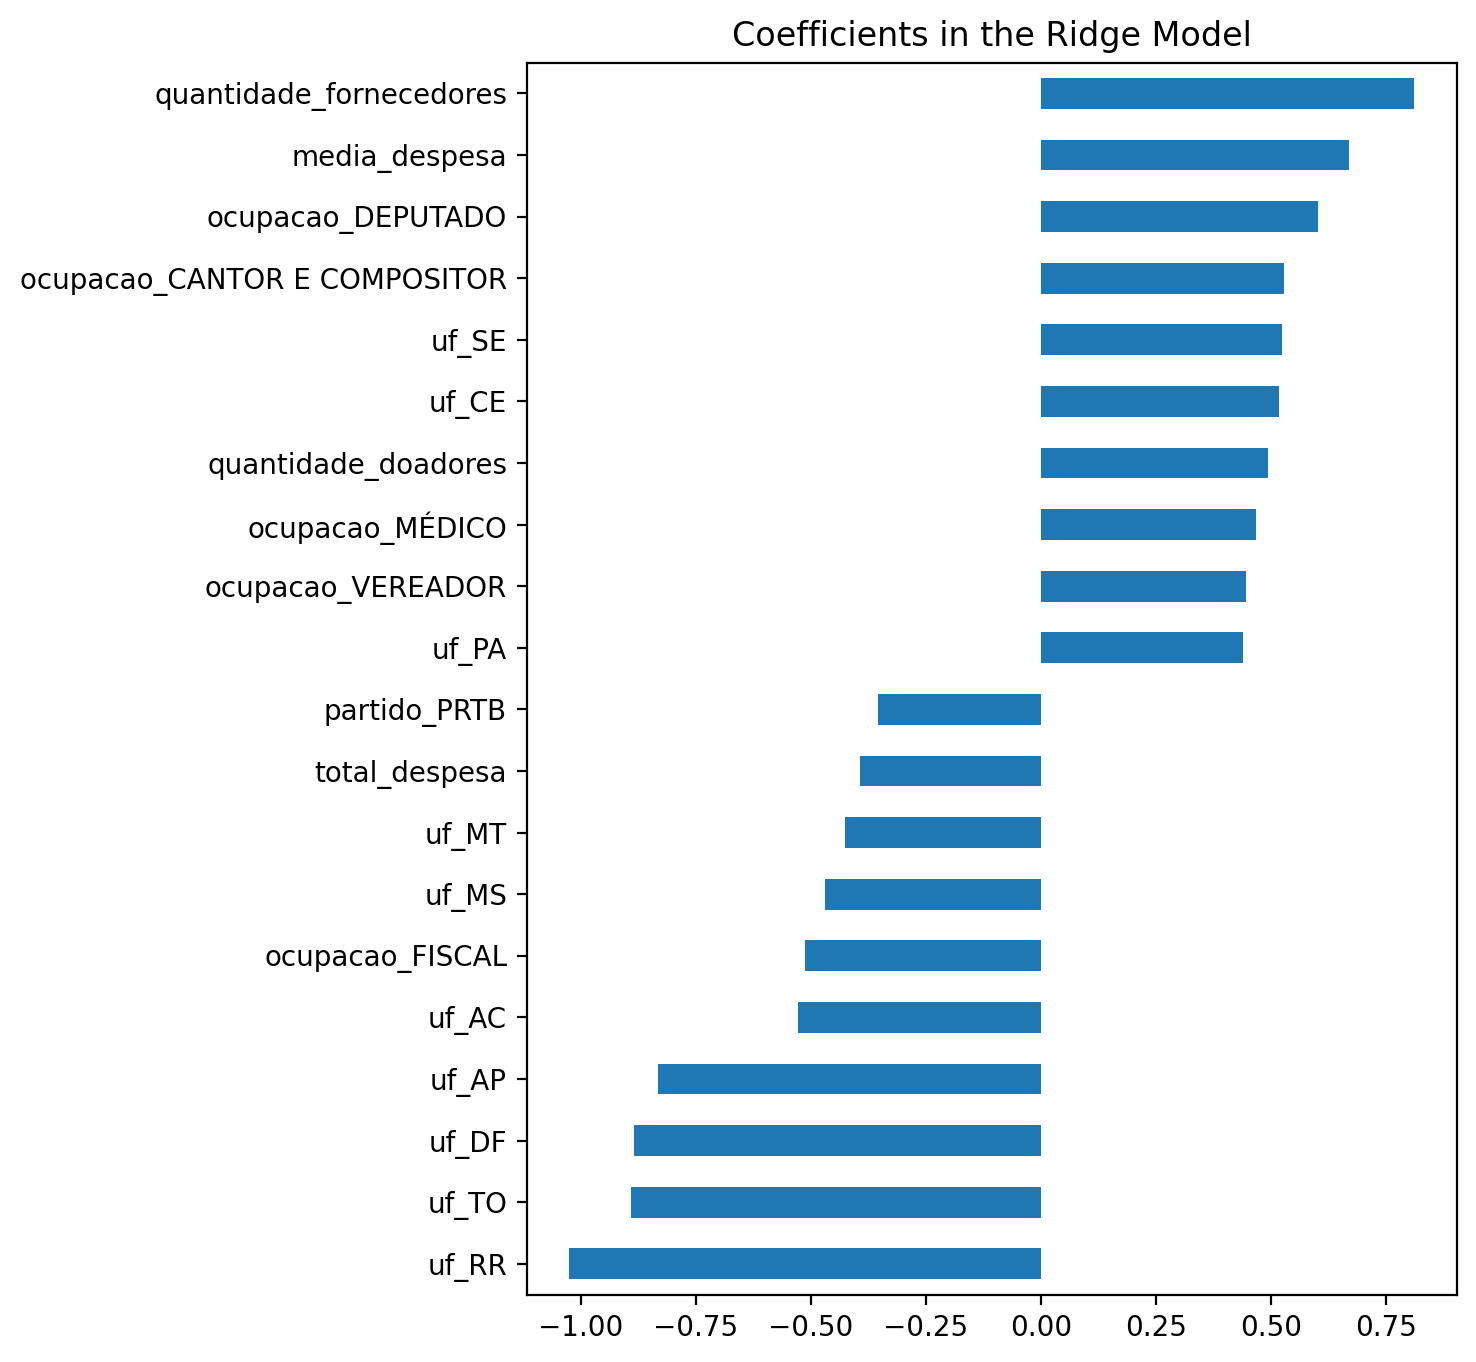

In [56]:
matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

<AxesSubplot:title={'center':'Ridge - residuals x preds'}, xlabel='preds', ylabel='residuals'>

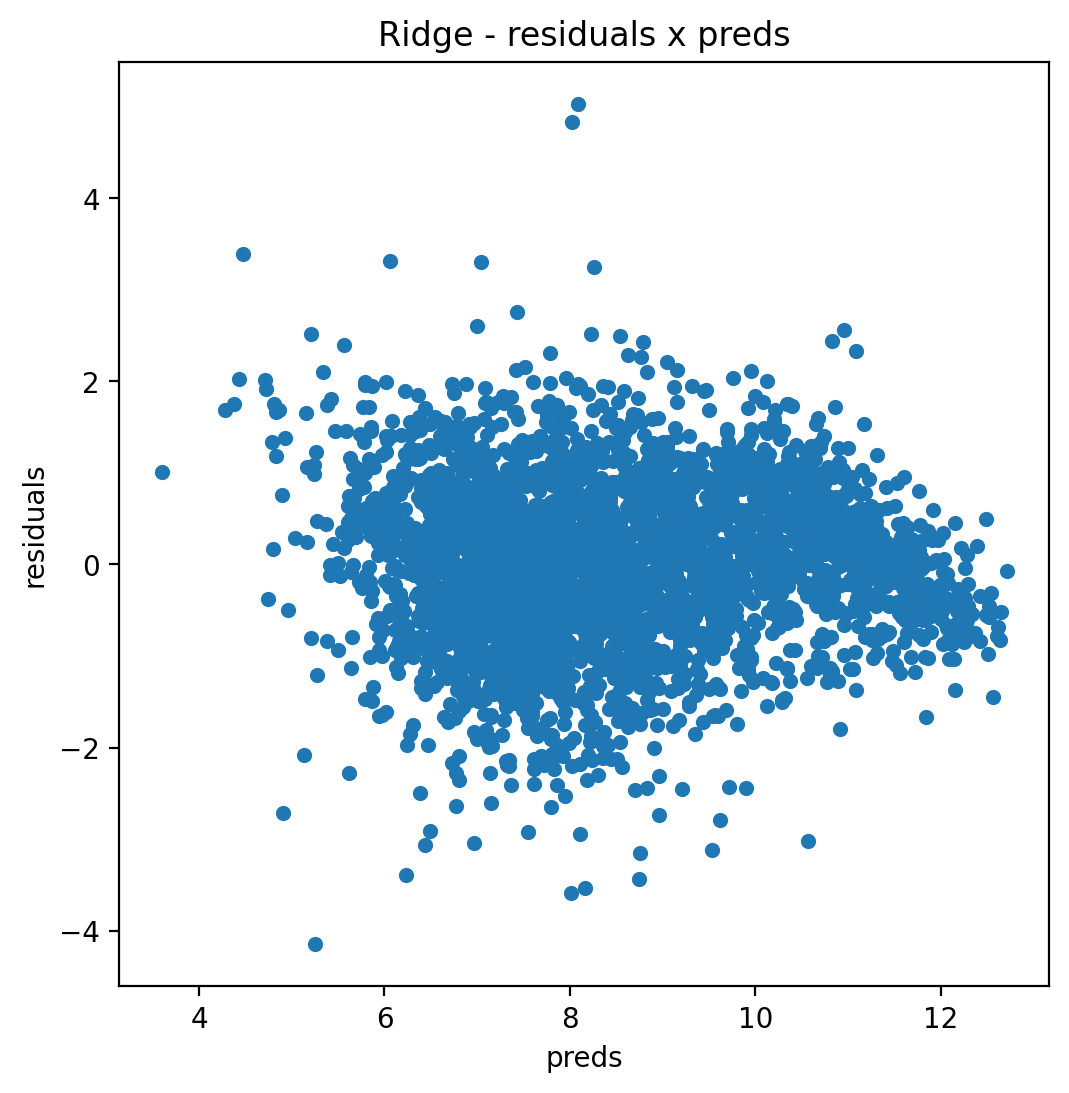

In [57]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train_2006), "true": y_train_2006})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter", title = "Ridge - residuals x preds")

### Análise dos resultados Ridge e Lasso

O RMSE no modelo Ridge nos dados de treino foi de 0.78, enquanto que o RMSE no modelo Lasso nos dados de treino foi de 0.77.

### 3 Modelo: SVR

In [58]:
# comentei porque demora um pouco para executar

#rmse_lista = []
#c_lista = []
#for i in range(1,3):
#    model_svr = svm.SVR(kernel='rbf', C = i)
#    model_svr.fit(X_train_2006, y_train_2006)
#    score = model_svr.score(X_train_2006, y_train_2006)
#    rmse_lista.append(model_svr.score(X_train_2006, y_train_2006))
#    c_lista.append(i)
#    
#s = pd.Series(rmse_lista, index = c_lista)

In [59]:
#plt.xlabel("Parâmetro C")
#plt.ylabel("RMSE")
#plt.title("RMSE x Parametro C")
#plt.plot(s.index, s.values)

O parâmetro C = 1 foi o que teve o menor RMSE no treino

In [60]:
#def testar_kernels(kernels):
#    for kernel in kernels:
#        classifier = svm.SVR(kernel=kernel, C=1)
#        cv_svr = rmse_cv(classifier, X_train_2006, y_train_2006).mean()
#        print("SVR RMSE CROSS: {}".format(cv_svr))
        
#['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
#kernels = ['poly', 'rbf', 'sigmoid'] # o tempo de processamento do kernel linear é alto em relação aos demais
#testar_kernels(kernels)

O kernel rbf foi o que teve o menor RMSE no treino e o parâmetro c = 1

In [61]:
model_svr = svm.SVR(kernel='rbf', C = 1)
model_svr.fit(X_train_2006, y_train_2006)
rmse = model_svr.score(X_train_2006, y_train_2006)
print("SVR - RMSE - Treino: {}".format(rmse)) 

SVR - RMSE - Treino: 0.7649335052622246


In [62]:
y_pred_svr = model_svr.predict(X_test_2010)

In [63]:
rmse = model_svr.score(X_test_2010, y_test_2010)
print("SVR - RMSE - Teste: {}".format(rmse)) 

SVR - RMSE - Test: 0.6945222895108456


<AxesSubplot:title={'center':'SVR - Residuals x preds'}, xlabel='preds', ylabel='residuals'>

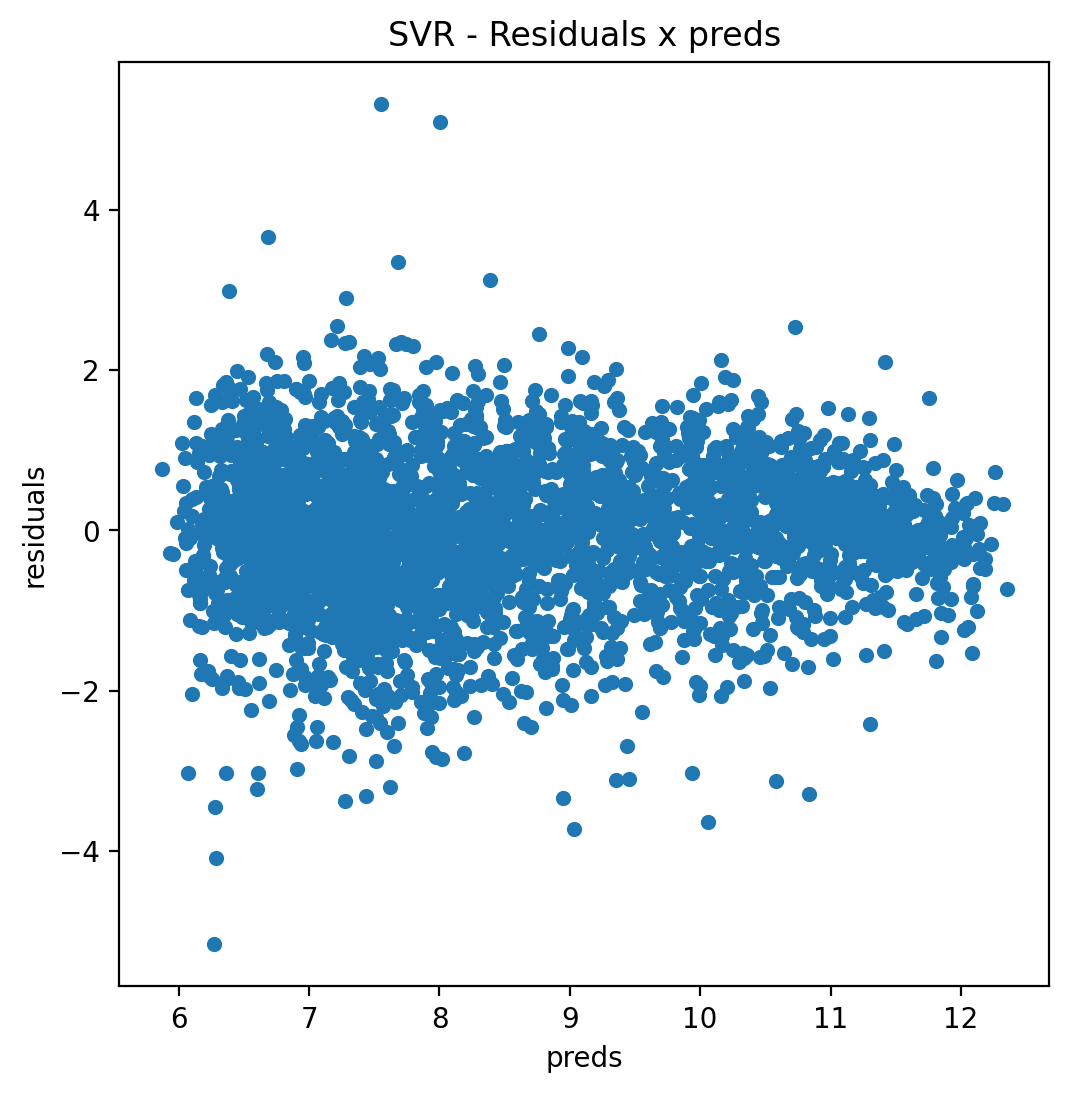

In [64]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_svr.predict(X_train_2006), "true": y_train_2006})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter", title="SVR - Residuals x preds")

### Análise dos resultados SVR com Ridge e Lasso 

O RMSE no modelo Ridge nos dados de treino foi de 0.78, enquanto que o RMSE no modelo Lasso nos dados de treino foi de 0.77. Já o RMSE do SVM no treino foi de 0.76. Portanto o modelo do SVR levando em consideração somente o RMSE é o melhor modelo.

### 4 Modelo: RandomForestRegressor

In [65]:
model_random = RandomForestRegressor(n_estimators = 50, random_state = 43, max_depth = 8)
model_random.fit(X_train_2006, y_train_2006)

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=43)

In [66]:
rmse = model_random.score(X_train_2006, y_train_2006)
print("RandoForest - RMSE - Treino: {}".format(rmse))

RandoForest - RMSE - Treino: 0.8466931102429369


In [67]:
rmse = -cross_val_score(model_random, X_train_2006, y_train_2006, scoring = "neg_mean_squared_error", cv = 5 )
print("RandoForest - RMSE - Cross - Treino: {}".format(rmse.mean()))

RandoForest - RMSE - Cross -Treino: 0.8909619042133562


In [68]:
rmse = model_random.score(X_test_2010, y_test_2010)
print("RandomForest - RMSE - Teste: {}".format(rmse))

RandoForest - RMSE - Teste: 0.7010254049934429


In [69]:
y_pred_random = model_random.predict(X_test_2010) 

<AxesSubplot:xlabel='preds', ylabel='residuals'>

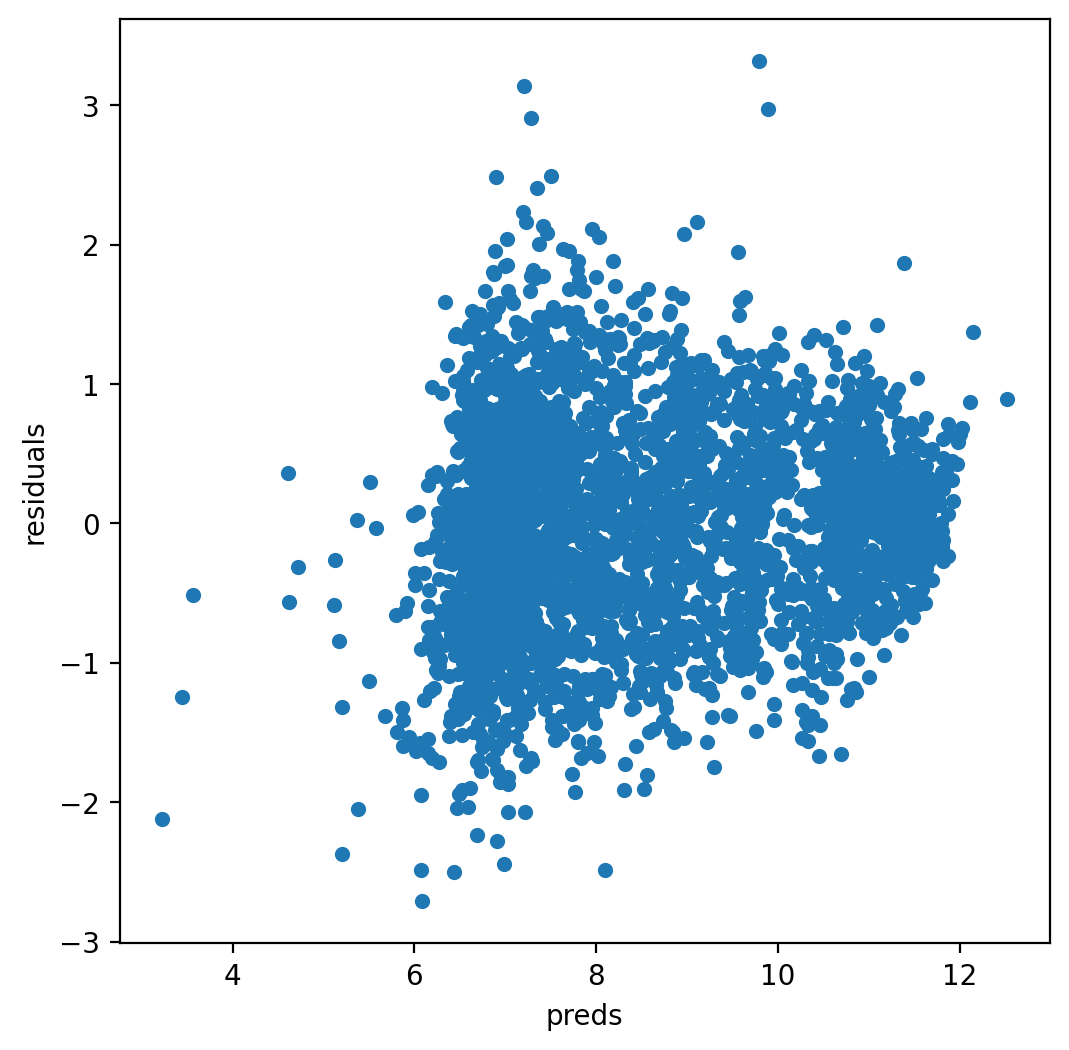

In [70]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_random.predict(X_train_2006), "true": y_train_2006})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

O RMSE no modelo Ridge nos dados de treino foi de 0.78, enquanto que o RMSE no modelo Lasso nos dados de treino foi de 0.77. Já o RMSE do SVM no treino foi de 0.76. Por fim, o RMSE do RandomForest foi de 0.84. Portanto o modelo do SVR levando em consideração somente o RMSE ainda é o melhor modelo.

### 5 Modelo: KNN 

In [71]:
model_knn = KNeighborsRegressor(n_neighbors=5)  
model_knn.fit(X_train_2006, y_train_2006)  

KNeighborsRegressor()

In [72]:
print("KNN - RSME - Treino: {} ".format(model_knn.score(X_train_2006, y_train_2006)))

KNN - RSME - Treino: 0.8151432980200035 


In [73]:
print("KNN - RSME - Teste: {} ".format(model_knn.score(X_test_2010, y_test_2010)))

KNN - RSME - Teste: 0.6899791467077583 


In [ ]:
rmse = -cross_val_score(model_knn, X_train_2006, y_train_2006, scoring = "neg_mean_squared_error", cv = 5 )
print("KNN - RSME - Cross - Treino: {} ".format(rmse.mean()))

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_knn.predict(X_train_2006), "true": y_train_2006})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

Para o KNN o RMSE no Treino foi de 0.81 e no Teste 0.68. Maior do que o do SVR para os dados de Treino.

## Analise dos Resultados

Foram avaliados, 5 modelos: Ridge, Lasso, SVR, RandomForest, KNN
Respectivamente os RMSEs no treino foram (0.78, 0.77, 0.76, 0.84 e 0.81)
Portanto o melhor modelo, somente levando em consideração o RMSE é o SVR ainda é o melhor modelo.

# Re-treino do Modelo com todos os dados (2006 e 2010) e validação com 2014

In [7]:
model_svr = svm.SVR(kernel='rbf', C = 1)
model_svr.fit(X_train_2006_2010, y_train_2006_2010)

SVR(C=1)

In [19]:
print("RMSE - SVR - Treino: {}".format(model_svr.score(X_train_2006_2010, y_train_2006_2010)))

RMSE - SVR - Treino: 0.7713072593971451


In [21]:
print("RMSE - SVR - Teste: {}".format(model_svr.score(X_test_2014, y_test_2014)))

RMSE - SVR - Teste: 0.4890311953570212


<AxesSubplot:xlabel='preds', ylabel='residuals'>

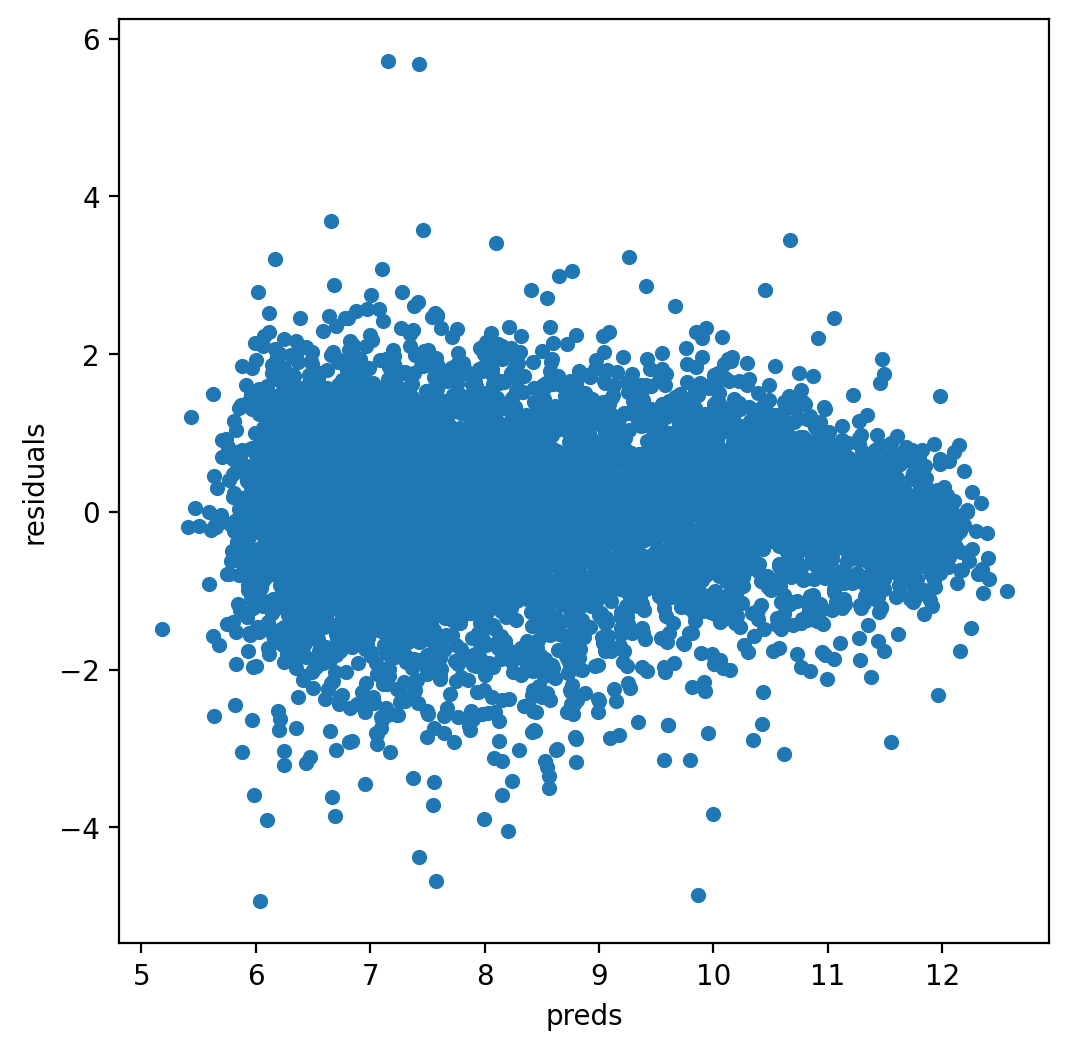

In [9]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_svr.predict(X_train_2006_2010), "true": y_train_2006_2010})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

In [10]:
y_pred_svr_model = model_svr.predict(X_test_2014)

In [16]:
solution = pd.DataFrame({"nome": X_test_2014.index,"votos":np.expm1(y_pred_svr_model).astype(int)})
solution.to_csv("pred_2014.csv")

In [17]:
solution = pd.DataFrame({"nome": X_test_2014.index,"votos":np.expm1(y_test_2014).astype(int)})
solution.to_csv("real_2014.csv")